# Analyse des Optimizers

Le rôle de l’optimizer est de définir comment évolue (apprend) une IA pour s’adapter aux données d’entraînement. Par défaut, on utilise souvent la Descente de Gradient Stochastique (SGD)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange

Nous allons ici créer un Neuronne Linéaire sans fonction d'activation, et nous allons l'entrainer à multiplier par la valeur cible.

In [2]:
class NeuronneLineaire:
    def __init__(self, pseudo_alea=True, lr=0.8, cible=0.5):
        if pseudo_alea:
            np.random.seed(2)
        self.w = np.random.random()
        self.lr = lr # le learning rate
        self.liste_w = [] # l'historique des poids
        self.liste_e = [] # l'historique des erreurs
        self.cible = cible # le poids ciblé par l'entrainement
        
    def calcul(self, x):
        return self.w * x # prédiction du résultat
    
    @staticmethod
    def erreur(y_, y): # y_ la sortie calculé, y la sortie souhaitée
        return (y - y_) ** 2
    
    @staticmethod
    def d_erreur(x, y_, y): # y_ la sortie calculé, y la sortie souhaitée
        return (2*(y_-y) * 1 * x).mean() # Calcul de la mise à niveau du poids
    
    def validation(self):
        e = self.erreur(self.w, self.cible)
        self.liste_w.append(self.w)
        self.liste_e.append(e)
        
    def calcul_dw(self, x, y):
        if type(x) == int:
            x, y = np.array([x]), np.array([y])
        y_ = self.calcul(x)
        dw = self.d_erreur(x, y_, y)
        return dw
    
    def retropropagation(self, x, y):
        dw = self.calcul_dw(x, y)
        self.w -= self.lr * dw # Mise à jour du poids
    
    def plot(self, ax=plt, title="", mini=None, maxi=None):
        cible = self.cible
        if mini is None:
            mini = min(self.liste_w)
            maxi = max(self.liste_w)
            mean = max(abs(mini-cible), abs(maxi-cible))/2
            x = np.linspace(min(mini-mean, cible-mean), 
                            max(maxi+mean, cible+mean), 
                            1_000)
        else:
            x = np.linspace(min(mini, min(self.liste_w)), 
                            max(maxi, max(self.liste_w)), 
                            1_000)
        
        y = self.erreur(x, self.cible) # calcul de la courbe d'erreur
        
        # ax.figure(figsize=(12, 6))
        ax.plot(x, y, label="Courbe d'erreur")
        ax.plot(self.liste_w, self.liste_e, 'o-', lw=3, label="Apprentissage")
        ax.set_title(title)
        ax.grid()
        ax.legend()

# Descente de Gradient Stochastique (SGD)

On remarquera que pour un grand learning rate, l'apprentissage oscille énormément autour de la valeure recherchée.  
Tandis que pour un petit learning rate, celui-ci descent assez lentement.

0.7317041265138073
0.7317041265138073


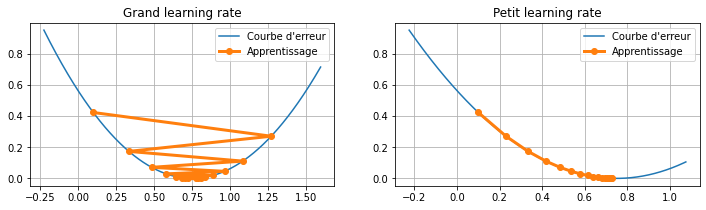

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

# Grand learning rate
reseau = NeuronneLineaire(lr=0.9, cible=0.75)
reseau.w = 0.1
for i in range(16):
    reseau.validation()
    reseau.retropropagation(1, 0.75)
print(reseau.calcul(1))
reseau.plot(ax=axs[0], title="Grand learning rate")

# Petit learning rate
reseau = NeuronneLineaire(lr=0.1, cible=0.75)
reseau.w = 0.1
for i in range(16):
    reseau.validation()
    reseau.retropropagation(1, 0.75)
print(reseau.calcul(1))
reseau.plot(ax=axs[1], title="Petit learning rate")

# SGD avec plusieurs entrées aléatoires

En réalité, lorsque que l'on entraine un réseau de neuronnes, les données d'entrainement ne sont jamais exactement les données rencontrées lors de l'utilisation. De plus les valeurs peuvent être sujet à de petites variations (bruit) aléatoire.  
Nous avons essayer de recréer ici cette environnemnet d'entrainement avec la fonction générer : 
$y = x \times cible + \delta \times bruit$  
avec $\delta \in [|-0.5, 0.5|]$ choisi aléatoirement.

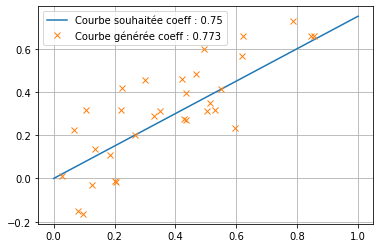

In [4]:
# on génère les entrées et sorties voulu
def generer(n, pseudo_alea=True, cible=0.5, bruit=0):
    if pseudo_alea:
        np.random.seed(2)
    x = np.random.random(n) # on génère l'entrée
    y = x * cible # on calcul la sortie pour chaque entrée
    y += (np.random.random(n) - 0.5) * bruit # on rajoute du bruit sur les sorties 
    # la variable bruit étant l'amplitude maximal du bruit appliquée
    
    return x, y
liste_x, liste_y = generer(32, pseudo_alea=True, cible=0.75, bruit=0.5) # courbe générée
liste_x_ = np.linspace(0, 1, 101)
liste_y_ = liste_x_ * 0.75 # Courbe souhaitée

plt.plot(liste_x_, liste_y_, label="Courbe souhaitée coeff : 0.75")
plt.plot(liste_x, liste_y, "x", 
         label=f"Courbe générée coeff : {round((liste_y/liste_x).mean(), 3)}")
plt.legend()
plt.grid()

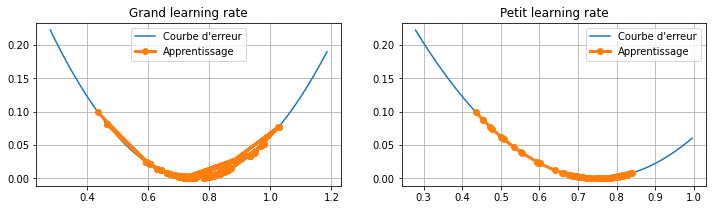

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

# Grand learning rate
reseau = NeuronneLineaire(lr=0.9, cible=0.75)
for i in range(4):
    for x, y in zip(liste_x, liste_y):
        reseau.validation()
        reseau.retropropagation(x, y)
reseau.plot(ax=axs[0], title="Grand learning rate")

# Petit learning rate
reseau = NeuronneLineaire(lr=0.1, cible=0.75)
for i in range(4):
    for x, y in zip(liste_x, liste_y):
        reseau.validation()
        reseau.retropropagation(x, y)
reseau.plot(ax=axs[1], title="Petit learning rate")

# SGD Mini Batch

On remarquera qu'avec l'utilisation du Batch, en entrainant sur plusieurs données en même temps (ici des groupes de 4 données) avant de mettre à jour le poids, cela permet d'être moins sujet au bruit de chaque donnée individuelle.

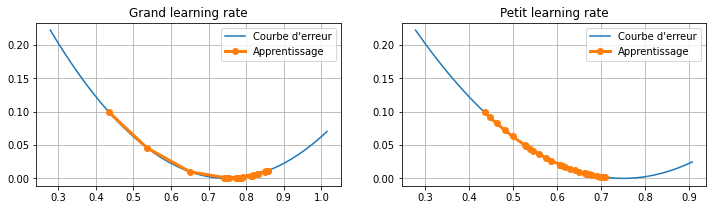

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

# Grand Learning rate
reseau = NeuronneLineaire(lr=0.9, cible=0.75)
for i in range(4):
    for i in range(0, 32, 4):
        x, y = liste_x[i:i+4], liste_y[i:i+4]
        reseau.validation()
        reseau.retropropagation(x, y)
reseau.plot(ax=axs[0], title="Grand learning rate")

# Petit Learning rate
reseau = NeuronneLineaire(lr=0.1, cible=0.75)
for i in range(4):
    for i in range(0, 32, 4):
        x, y = liste_x[i:i+4], liste_y[i:i+4]
        reseau.validation()
        reseau.retropropagation(x, y)
reseau.plot(ax=axs[1], title="Petit learning rate")

# Descente de Gradient

L'idée de mettre toutes les données dans le batch et d'entrainer tout d'un coup, est cependant mauvaise, car le réseau de neuronne ne se met pas à jour assez régulièrement. Ce qui entraine une convergence vers le minimum très lent.

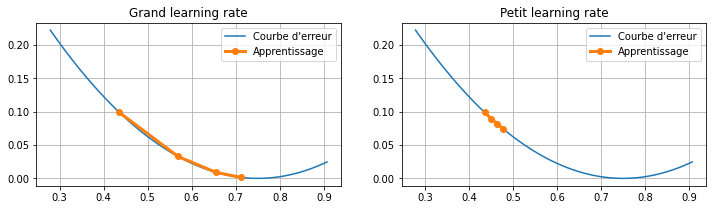

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

# Grand Learning rate
reseau = NeuronneLineaire(lr=0.9, cible=0.75)
for i in range(4):
    reseau.validation()
    reseau.retropropagation(liste_x, liste_y)
reseau.plot(ax=axs[0], title="Grand learning rate")

# Petit Learning rate
reseau = NeuronneLineaire(lr=0.1, cible=0.75)
for i in range(4):
    reseau.validation()
    reseau.retropropagation(liste_x, liste_y)
reseau.plot(ax=axs[1], title="Petit learning rate")

# Poursuite des Recherches

D'autre paremètres peuvent encore être pris en compte :  
- l'accélération (Si l'on se trouve encore loin du minimum, on accélère)  
- le moment (Pour ne pas rester bloquer dans un minimum local)   
   
D'autres Optimizer basé sur le SGD :   
- Momentum   
- Nesterov accelerated gradient   
- Adagrad    
- Adadelta   
- RMSprop   
- Adam (couramment utilisé)   

# Moment  
https://ruder.io/optimizing-gradient-descent/index.html#gradientdescentoptimizationalgorithms

### Sans Moment

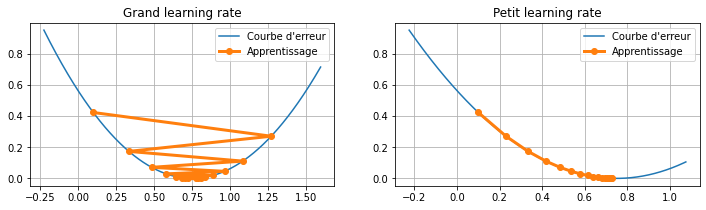

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

# Grand learning rate
reseau1 = NeuronneLineaire(lr=0.9, cible=0.75)
reseau1.w = 0.1
# Petit learning rate
reseau2 = NeuronneLineaire(lr=0.1, cible=0.75)
reseau2.w = 0.1
# Entrainement
for i in range(16):
    reseau1.validation()
    reseau1.retropropagation(1, 0.75)
    reseau2.validation()
    reseau2.retropropagation(1, 0.75)
reseau1.plot(ax=axs[0], title="Grand learning rate")
reseau2.plot(ax=axs[1], title="Petit learning rate")

### Avec Moment

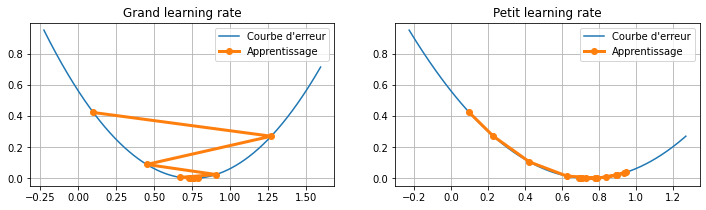

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

# Grand Learning rate
reseau = NeuronneLineaire(lr=0.9, cible=0.75)
reseau.w = 0.1
gamma = 0.1
dw_moment_ = 0
for i in range(16):
    reseau.validation()
    dw = reseau.calcul_dw(1, 0.75)
    dw_moment = gamma * dw_moment_ + reseau.lr * dw
    reseau.w -= dw_moment
    dw_moment_ = dw_moment
reseau.plot(ax=axs[0], title="Grand learning rate")

# Grand Learning rate
reseau = NeuronneLineaire(lr=0.1, cible=0.75)
reseau.w = 0.1
gamma = 0.7
dw_moment_ = 0
for i in range(16):
    reseau.validation()
    dw = reseau.calcul_dw(1, 0.75)
    dw_moment = gamma * dw_moment_ + reseau.lr * dw
    reseau.w -= dw_moment
    dw_moment_ = dw_moment
reseau.plot(ax=axs[1], title="Petit learning rate")

#### Lagrange loss

       4      3         2
21.33 x - 40 x + 24.67 x - 6 x + 1
[0.78182458 0.3990627  0.22536273]
0.7818245754575138


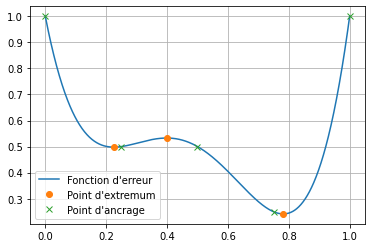

In [3]:
poly = lagrange(
    [0, 0.25, 0.5, 0.75, 1], 
    [1, 0.5, 0.5, 0.25, 1]
)

x = np.linspace(0, 1, 1000)
y = poly(x)
plt.plot(x, y, label="Fonction d'erreur")
plt.grid()

deriv = poly.deriv()
x_extr = deriv.r
y_extr = poly(x_extr)
plt.plot(x_extr, y_extr, 'o', label="Point d'extremum")
plt.plot(
    [0, 0.25, 0.5, 0.75, 1], 
    [1, 0.5, 0.5, 0.25, 1],
    "x",
    label="Point d'ancrage"
)
plt.legend()

print(poly)
print(x_extr)
cible = x_extr[0]
print(cible)

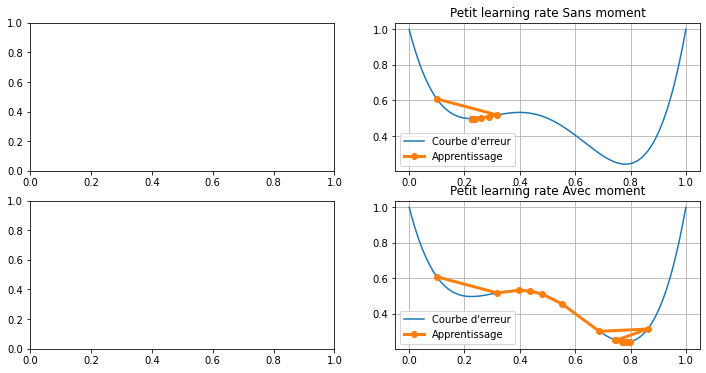

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

def erreur(y_, y):
    e  = poly(y_) # calcul de l'erreur 
    return e

def d_erreur(x, y_, y):
    return (deriv(y_) * 1 * x).mean() # Calcul de la mise à niveau du poids

# Grand learning rate
""" Ne fonctionne pas pour un grand learning rate dû à la grande dérivée
"""

# Petit learning rate
reseau2 = NeuronneLineaire(lr=0.1, cible=cible)
reseau2.w = 0.1
reseau2.erreur = erreur
reseau2.d_erreur = d_erreur

# Entrainement
for i in range(16):
    reseau2.validation()
    reseau2.retropropagation(1, cible)
reseau2.plot(ax=axs[0, 1], title="Petit learning rate Sans moment", mini=0, maxi=1)

# Petit Learning rate
reseau = NeuronneLineaire(lr=0.1, cible=cible)
reseau.w = 0.1
gamma = 0.5
dw_moment_ = 0
reseau.erreur = erreur
reseau.d_erreur = d_erreur
for i in range(16):
    reseau.validation()
    dw = reseau.calcul_dw(1, cible)
    dw_moment = gamma * dw_moment_ + reseau.lr * dw
    reseau.w -= dw_moment
    dw_moment_ = dw_moment
reseau.plot(ax=axs[1, 1], title="Petit learning rate Avec moment", mini=0, maxi=1)

# Nesterov accelerated gradient

0.22555550391853058


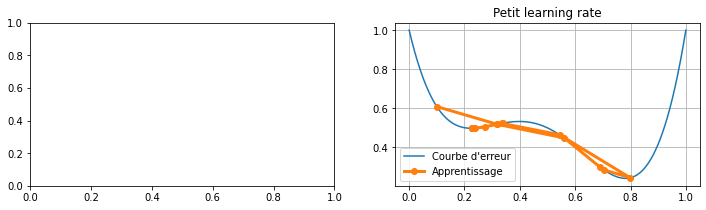

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

# Grand Learning rate ne marche pas pour les mêmes raisons

# Petit Learning rate
reseau = NeuronneLineaire(lr=0.1, cible=cible)
reseau.w = 0.1
reseau.erreur = erreur
reseau.d_erreur = d_erreur
gamma = 0.7
dw_moment_ = 0
for i in range(16):
    reseau.validation()
    w = reseau.w
    reseau.w = w - dw_moment_
    dw = reseau.calcul_dw(1, cible)
    dw_moment = gamma * dw_moment_ + reseau.lr * dw
    reseau.w = w - dw_moment
    dw_moment_ = dw_moment
reseau.plot(ax=axs[1], title="Petit learning rate", mini=0, maxi=1)
print(reseau.w) # Honnetement c'est bof